In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evds import evdsAPI
from datetime import date

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
usd["TP_DK_USD_S_YTL"].iloc[-1]=26.39

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
205,2023-3,1269.75
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59


In [5]:
inflation=enf
inflation=pd.DataFrame(inflation)
inflation.columns=["Tarih","TÜFE"]


In [6]:

inflationagt={'Tarih':'2023-8','TÜFE':[1570]}
inflationagt=pd.DataFrame.from_dict(inflationagt)
inflation=pd.concat([inflation,inflationagt],axis=0)
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
206,2023-4,1300.04
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84


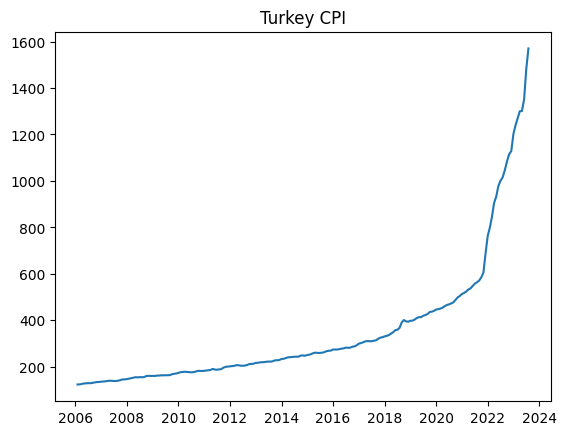

In [7]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure()
plt.title("Turkey CPI")

plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6.iloc[209,0]=26.94
df6

,USD/TL
0,1.326535
1,1.335139
2,1.337345
3,1.420659
4,1.600536
...,...
206,19.337032
207,19.719514
208,23.106042
209,26.940000


In [11]:
dates= pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

            
df6=df6.set_index(dates)

df6["Onceki USD/TL"]=df6["USD/TL"].shift(1)
df6.iloc[0,1]=1.32
df6

,USD/TL,Onceki USD/TL
2006-02-01,1.326535,1.320000
2006-03-01,1.335139,1.326535
2006-04-01,1.337345,1.335139
2006-05-01,1.420659,1.337345
2006-06-01,1.600536,1.420659
...,...,...
2023-04-01,19.337032,19.003478
2023-05-01,19.719514,19.337032
2023-06-01,23.106042,19.719514
2023-07-01,26.940000,23.106042


In [12]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
money

,Tarih,TP_PR_ARZ13
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [13]:
#Cleaning the data

money_supply=pd.DataFrame(money)
money_supply.columns=["Tarih","Para Arzi"]
money_supply["Para Arzi"]=money_supply["Para Arzi"].astype(float)
money_supply


,Tarih,Para Arzi
0,2006-2,2.423895e+08
1,2006-3,2.494857e+08
2,2006-4,2.521919e+08
3,2006-5,2.751947e+08
4,2006-6,2.791388e+08
...,...,...
206,2023-4,9.505999e+09
207,2023-5,9.409317e+09
208,2023-6,1.083453e+10
209,2023-7,1.147848e+10


In [14]:
money_supply=money_supply.set_index(dates)
money_supply["Para Arzi"]=money_supply["Para Arzi"]/1e+08
money_supply
dfn=pd.DataFrame(money_supply)
del dfn["Tarih"]
dfn["Para Arzi Onceki"]=dfn["Para Arzi"].shift(1)
dfn.iloc[0,1]=2.39
dfn


,Para Arzi,Para Arzi Onceki
2006-02-01,2.423895,2.390000
2006-03-01,2.494857,2.423895
2006-04-01,2.521919,2.494857
2006-05-01,2.751947,2.521919
2006-06-01,2.791388,2.751947
...,...,...
2023-04-01,95.059993,90.592762
2023-05-01,94.093167,95.059993
2023-06-01,108.345324,94.093167
2023-07-01,114.784753,108.345324


In [15]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
brent.iloc[210,1]=83
brent

,Tarih,TP_BRENTPETROL_EUBP
0,2006-2,59.78
1,2006-3,66.06
2,2006-4,72.15
3,2006-5,67.57
4,2006-6,73.20
...,...,...
206,2023-4,81.32
207,2023-5,71.98
208,2023-6,74.51
209,2023-7,85.22


In [16]:

brent1=pd.DataFrame(brent)
brent1.columns=["Tarih","Brent"]
brent1


,Tarih,Brent
0,2006-2,59.78
1,2006-3,66.06
2,2006-4,72.15
3,2006-5,67.57
4,2006-6,73.20
...,...,...
206,2023-4,81.32
207,2023-5,71.98
208,2023-6,74.51
209,2023-7,85.22


In [17]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)

df14["Brent"]=brent1["Brent"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-01,59.78
2006-03-01,66.06
2006-04-01,72.15
2006-05-01,67.57
2006-06-01,73.20
...,...
2023-04-01,81.32
2023-05-01,71.98
2023-06-01,74.51


In [18]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
206,2023-4,8.572114e+09
207,2023-5,8.804344e+09
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09


In [19]:
dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
206,2023-4,85.721139
207,2023-5,88.043441
208,2023-6,95.646045
209,2023-7,98.468952


In [20]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3

,Kredi
TIME,
2006-02-01,1.381847
2006-03-01,1.481222
2006-04-01,1.527510
2006-05-01,1.664881
2006-06-01,1.740395
...,...
2023-04-01,85.721139
2023-05-01,88.043441
2023-06-01,95.646045


In [21]:
faiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
faiz

,Tarih,TP_KTFTUK
0,2006-2,17.2975
1,2006-3,17.0080
2,2006-4,16.2075
3,2006-5,16.3000
4,2006-6,19.6700
...,...,...
206,2023-4,29.2275
207,2023-5,32.0225
208,2023-6,38.5600
209,2023-7,45.8250


In [22]:

dates=pd.date_range('2006-02-01','2023-09-01' , freq='1M')-pd.offsets.MonthBegin(1)
faiz=pd.DataFrame(faiz)
faiz.columns=["Tarih","Faiz"]
faiz

,Tarih,Faiz
0,2006-2,17.2975
1,2006-3,17.0080
2,2006-4,16.2075
3,2006-5,16.3000
4,2006-6,19.6700
...,...,...
206,2023-4,29.2275
207,2023-5,32.0225
208,2023-6,38.5600
209,2023-7,45.8250


In [23]:
df4=pd.DataFrame()
df4["Faiz"]=faiz["Faiz"]
df4["TIME"]=dates
df4['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df4['TIME'] =  pd.to_datetime(df4['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df4 = df4.set_index(['TIME'])
df4

,Faiz
TIME,
2006-02-01,17.2975
2006-03-01,17.0080
2006-04-01,16.2075
2006-05-01,16.3000
2006-06-01,19.6700
...,...
2023-04-01,29.2275
2023-05-01,32.0225
2023-06-01,38.5600


In [97]:
X=pd.concat([df6["Onceki USD/TL"],dfn["Para Arzi Onceki"],df14.Brent,df3.Kredi,df4["Faiz"]],axis=1)



In [98]:
y=pd.DataFrame(df["CPI"])
y["CPI"]=y["CPI"].astype(float)
y


,CPI
2006-02-01,123.84
2006-03-01,124.18
2006-04-01,125.84
2006-05-01,128.20
2006-06-01,128.63
...,...
2023-04-01,1300.04
2023-05-01,1300.60
2023-06-01,1351.59
2023-07-01,1479.84


In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [100]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()

# Modelin özetini görüntüleyin
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     9287.
Date:                Thu, 24 Aug 2023   Prob (F-statistic):          1.18e-175
Time:                        15:29:06   Log-Likelihood:                -605.53
No. Observations:                 147   AIC:                             1223.
Df Residuals:                     141   BIC:                             1241.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               88.8232      6.986  

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [101]:
results.params

const               88.823200
Onceki USD/TL       16.092716
Para Arzi Onceki     6.073337
Brent                0.225940
Kredi                3.494497
Faiz                -0.350334
dtype: float64

In [26]:
from pmdarima.arima import auto_arima

results = auto_arima(df14, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1509.594, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1444.204, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1493.404, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1421.691, Time=3.59 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.04 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1434.273, Time=0.74 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1423.010, Time=1.00 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1423.155, Time=1.03 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1421.362, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1445.599, Time=0.26 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=2.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=i

In [37]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df14.astype(float),
                                order=(0,1,0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [38]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [39]:
pred_ci['Predicted'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
pred_ci['Observed'] = df14["Brent"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Brent,upper Brent,Predicted,Observed,"Diff, %%"
2022-11-01,76.905154,109.480022,93.192588,85.61,8.857129
2022-12-01,74.033332,106.608200,90.320766,82.82,9.056709
2023-01-01,69.383173,101.958041,85.670607,83.42,2.697923
2023-02-01,71.263987,103.838855,87.551421,83.21,5.217427
2023-03-01,54.015046,86.589914,70.302480,79.19,-11.223033
2023-04-01,65.564157,98.139024,81.851590,81.32,0.653702
2023-05-01,78.036111,110.610978,94.323545,71.98,31.041323
2023-06-01,58.206159,90.781027,74.493593,74.51,-0.022020
2023-07-01,55.857585,88.432453,72.145019,85.22,-15.342620
2023-08-01,63.057832,95.632700,79.345266,83.00,-4.403294


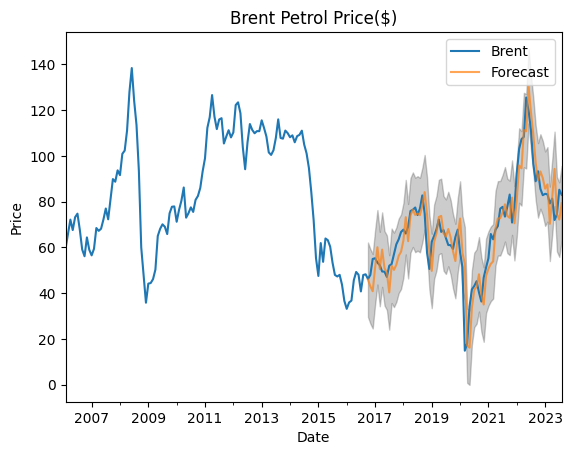

In [40]:
ax = df14['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")
plt.legend()
plt.show()

In [41]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

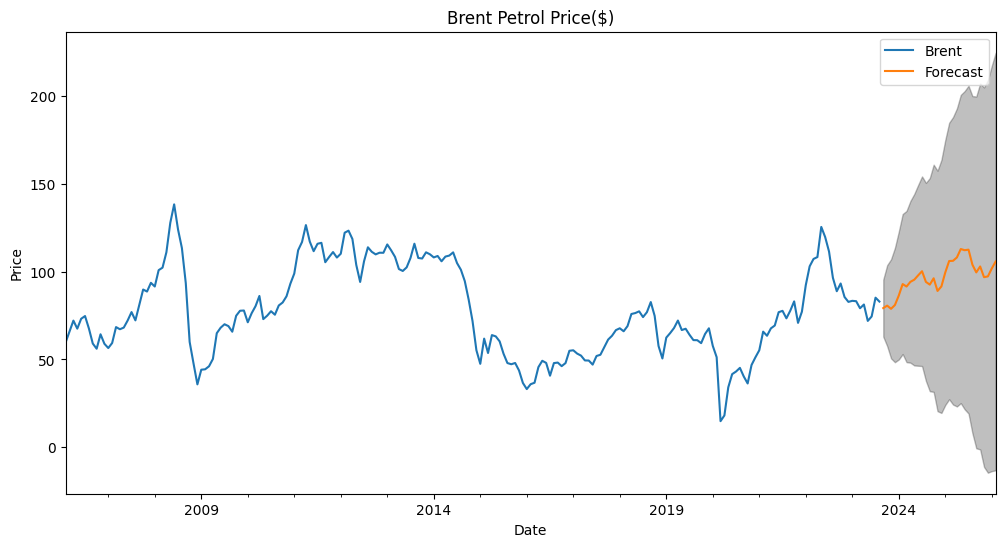

In [42]:
ax = df14.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("Brent Petrol Price($)")

plt.legend()

plt.show()

In [43]:
pred_ci['Mean'] = (pred_ci["lower Brent"] + pred_ci["upper Brent"])/2
brenttahmin=pred_ci["Mean"]
brenttahmin=pd.DataFrame(brenttahmin)
brenttahmin.columns=["Brent"]
brenttahmin=pd.concat([df14.tail(1),brenttahmin],axis=0)
brenttahmin



,Brent
2023-08-01,83.000000
2023-09-01,79.279617
2023-10-01,80.694623
2023-11-01,78.866909
2023-12-01,81.020911
2024-01-01,86.418859
2024-02-01,92.973199
2024-03-01,91.573110
2024-04-01,94.243312
2024-05-01,95.466777


In [34]:
from pmdarima.arima import auto_arima

results = auto_arima(dfn["Para Arzi"], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=615.446, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=645.603, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=644.423, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=645.155, Time=0.27 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=635.592, Time=0.27 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=616.879, Time=1.16 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=616.647, Time=5.53 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=618.578, Time=2.09 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=7.51 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=644.106, Time=0.17 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=616.190, Time=1.06 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=615.907, Time=1.01 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=646.069, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=643.304, Time=0.35 sec
 ARIMA(2,1,0)(0,1,1)[12]             

In [44]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(dfn["Para Arzi Onceki"].astype(float),
                                order=(1,1,1),
                                seasonal_order=(0,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [45]:
pred = results.get_prediction(start=pd.to_datetime('2016-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [46]:
pred_ci['Predicted'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
pred_ci['Observed'] = dfn["Para Arzi Onceki"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Para Arzi Onceki,upper Para Arzi Onceki,Predicted,Observed,"Diff, %%"
2022-11-01,76.363208,80.447240,78.405224,77.750311,0.842328
2022-12-01,79.789154,83.873018,81.831086,79.312824,3.175101
2023-01-01,80.898898,84.982596,82.940747,82.127970,0.989647
2023-02-01,83.540275,87.623811,85.582043,84.330974,1.483523
2023-03-01,85.914932,89.998467,87.956700,86.852197,1.271704
2023-04-01,89.281281,93.364654,91.322968,90.592762,0.806031
2023-05-01,92.890070,96.973282,94.931676,95.059993,-0.134985
2023-06-01,97.779679,101.862733,99.821206,94.093167,6.087625
2023-07-01,96.514699,100.597599,98.556149,108.345324,-9.035161
2023-08-01,111.519008,115.601756,113.560382,114.784753,-1.066667


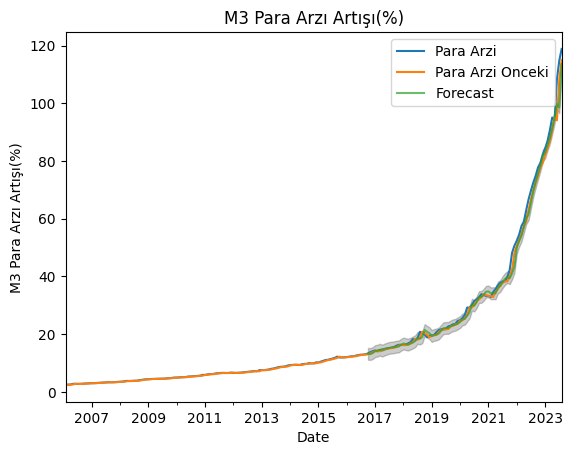

In [39]:
ax = dfn['2003':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.xlabel('Date')
plt.ylabel('M3 Para Arzı Artışı(%)')
plt.title("M3 Para Arzı Artışı(%)")
plt.legend()
plt.show()

In [47]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

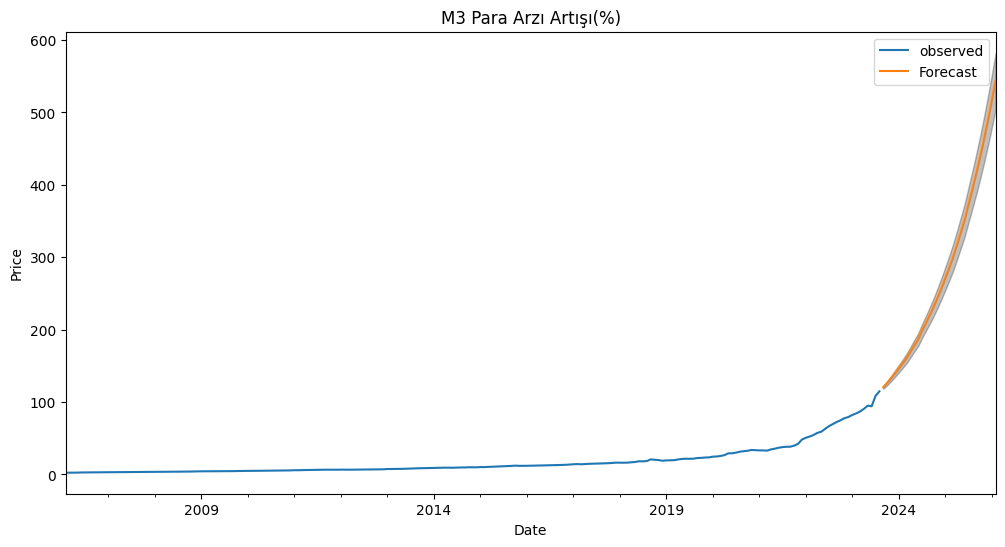

In [48]:
ax = dfn["Para Arzi Onceki"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("M3 Para Arzı Artışı(%)")

plt.legend()

plt.show()

In [49]:
import random
import numpy as np
pred_ci['Mean'] = (pred_ci["lower Para Arzi Onceki"] + pred_ci["upper Para Arzi Onceki"])/2
paraarzitahmin=pred_ci["Mean"]
paraarzitahmin=pd.concat([dfn["Para Arzi Onceki"].tail(1),paraarzitahmin])
paraarzitahmin=pd.DataFrame(paraarzitahmin)
paraarzitahmin.columns=["Para Arzi Tahmin"]



drop_percentage = random.uniform(1.01, 1.03)
drop_percentage1 = random.uniform(1.005, 1.01)
paraarzitahmin["Para Arzi Assumption 2"]=paraarzitahmin["Para Arzi Tahmin"]
paraarzitahmin["Para Arzi Assumption 3"]=paraarzitahmin["Para Arzi Tahmin"]
for i in range(0, len(paraarzitahmin)-1):
   
   paraarzitahmin["Para Arzi Assumption 2"][i+1]=paraarzitahmin["Para Arzi Assumption 2"][i]*drop_percentage
   paraarzitahmin["Para Arzi Assumption 3"][i+1]=paraarzitahmin["Para Arzi Assumption 3"][i]*drop_percentage1


paraarzitahmin

,Para Arzi Tahmin,Para Arzi Assumption 2,Para Arzi Assumption 3
2023-08-01,114.784753,114.784753,114.784753
2023-09-01,120.343514,118.045234,115.801306
2023-10-01,126.071248,121.398330,116.826863
2023-11-01,132.386958,124.846671,117.861502
2023-12-01,139.076030,128.392963,118.905303
2024-01-01,145.980095,132.039988,119.958349
2024-02-01,152.864893,135.790607,121.020721
2024-03-01,160.234033,139.647763,122.092501
2024-04-01,168.816117,143.614483,123.173774
2024-05-01,177.730605,147.693878,124.264622


In [42]:
from pmdarima.arima import auto_arima

results = auto_arima(df6, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=190.945, Time=1.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=283.960, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=209.451, Time=0.53 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=188.989, Time=0.86 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=242.739, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=187.008, Time=0.76 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=186.633, Time=0.30 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=187.160, Time=0.77 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=188.764, Time=3.50 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=252.549, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=188.475, Time=0.47 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=188.490, Time=0.45 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=190.409, Time=1.10 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=185.542, Time=1.54 sec
 ARIMA(0,1,1)(0,1,0)[12] intercep

In [79]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df6["USD/TL"].astype(float),
                                order=(0,1,1),
                                seasonal_order=(1,1,1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [80]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [81]:
pred_ci['Predicted'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
pred_ci['Observed'] = df6["USD/TL"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower USD/TL,upper USD/TL,Predicted,Observed,"Diff, %%"
2022-11-01,18.166534,19.795731,18.981132,18.624382,1.915503
2022-12-01,17.899379,19.528577,18.713978,18.670545,0.232625
2023-01-01,17.578199,19.207397,18.392798,18.791373,-2.121052
2023-02-01,18.040338,19.669536,18.854937,18.857210,-0.012053
2023-03-01,18.656628,20.285825,19.471226,19.003478,2.461381
2023-04-01,18.306061,19.935258,19.120660,19.337032,-1.118952
2023-05-01,19.000588,20.629785,19.815187,19.719514,0.485167
2023-06-01,19.269749,20.898947,20.084348,23.106042,-13.077506
2023-07-01,24.535957,26.165154,25.350555,26.940000,-5.899943
2023-08-01,27.285537,28.914734,28.100135,26.390000,6.480240


In [82]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

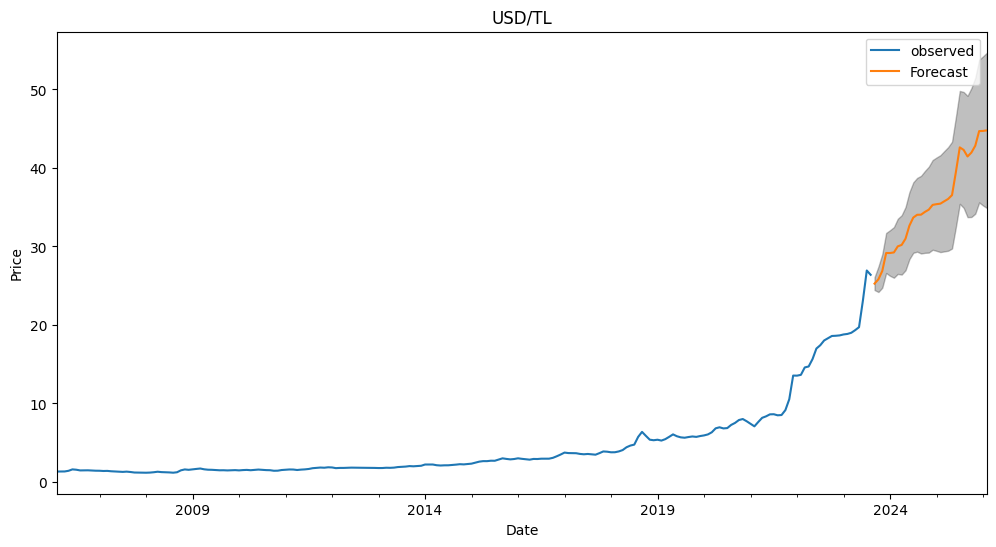

In [54]:
ax = df6["USD/TL"].plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title("USD/TL")

plt.legend()

plt.show()

In [84]:
pred_ci['Mean'] = (pred_ci["lower USD/TL"] + pred_ci["upper USD/TL"])/2
usdtahmin=pred_ci["Mean"]
usdtahmin=pd.concat([df6["USD/TL"].tail(1),usdtahmin])
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USD Tahmin"]

drop_percentage = random.uniform(1.001, 1.01)
usdtahmin["USD Tahmin Assumption 2"]=usdtahmin["USD Tahmin"]
for i in range(0, len(usdtahmin)-1):
   
   usdtahmin["USD Tahmin Assumption 2"][i+1]=usdtahmin["USD Tahmin Assumption 2"][i]*drop_percentage




usdtahmin["USD Tahmin"]=usdtahmin["USD Tahmin"].shift(1)
usdtahmin.iloc[0,0]=26.94
usdtahmin

,USD Tahmin,USD Tahmin Assumption 2
2023-08-01,26.940000,26.390000
2023-09-01,26.390000,26.528922
2023-10-01,25.265725,26.668576
2023-11-01,25.815752,26.808964
2023-12-01,26.881841,26.950092
2024-01-01,29.167976,27.091963
2024-02-01,29.166689,27.234580
2024-03-01,29.240412,27.377948
2024-04-01,30.017024,27.522071
2024-05-01,30.197145,27.666953


In [49]:
from pmdarima.arima import auto_arima

results = auto_arima(df3, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=437.234, Time=1.05 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=509.540, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=466.494, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=470.859, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=481.050, Time=0.12 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=438.459, Time=1.33 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=438.705, Time=3.11 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=441.108, Time=0.69 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=438.840, Time=4.64 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=463.632, Time=0.35 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=437.567, Time=1.61 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=436.033, Time=1.12 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=482.795, Time=0.25 sec
 ARIMA(1,1,2)(1,1,1)[12]             : AIC=437.622, Time=1.33 sec
 ARIMA(1,1,2)(0,1,2)[12]         

In [58]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df3.astype(float),
                                order=(3,1,0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [59]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [60]:
pred_ci['Predicted'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
pred_ci['Observed'] = df3["Kredi"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Kredi,upper Kredi,Predicted,Observed,"Diff, %%"
2022-11-01,68.408605,71.185056,69.796831,69.536996,0.373664
2022-12-01,69.698597,72.475049,71.086823,72.851339,-2.422078
2023-01-01,72.577087,75.353539,73.965313,75.079809,-1.484416
2023-02-01,75.602198,78.378649,76.990424,77.112692,-0.158559
2023-03-01,79.136514,81.912966,80.524740,82.109915,-1.930553
2023-04-01,83.954075,86.730526,85.342301,85.721139,-0.441942
2023-05-01,87.395546,90.171997,88.783772,88.043441,0.840870
2023-06-01,90.039882,92.816333,91.428108,95.646045,-4.409944
2023-07-01,97.540002,100.316454,98.928228,98.468952,0.466417
2023-08-01,98.953939,101.730391,100.342165,99.294996,1.054604


In [61]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

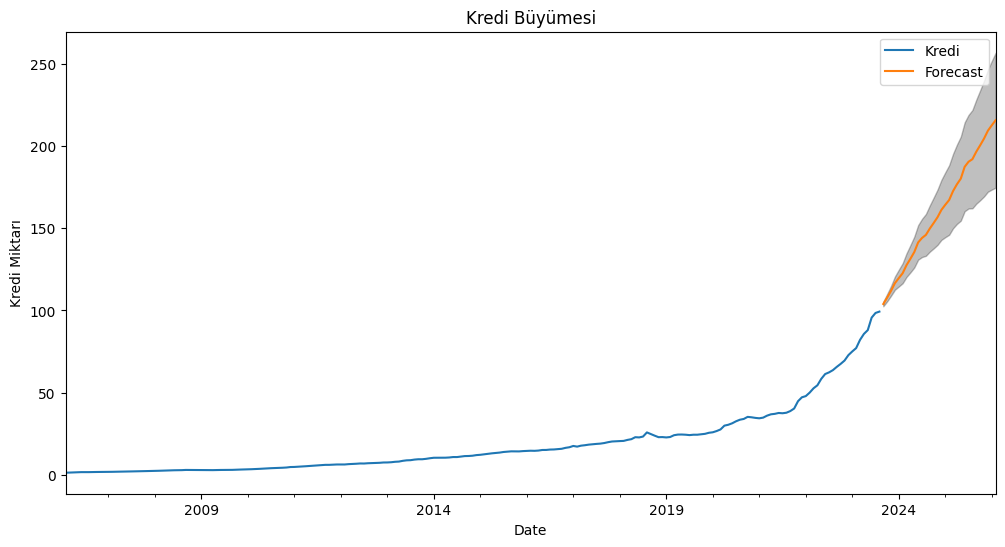

In [63]:
ax = df3.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Kredi Miktarı')
plt.title("Kredi Büyümesi")

plt.legend()

plt.show()

In [62]:
import random
pred_ci['Mean'] = (pred_ci["lower Kredi"] + pred_ci["upper Kredi"])/2
kreditahmin=pred_ci["Mean"]
kreditahmin=pd.concat([df3["Kredi"].tail(1),kreditahmin])
kreditahmin=pd.DataFrame(kreditahmin)
kreditahmin.columns=["Kredi Tahmin"]

drop_percentage = random.uniform(1.005, 1.01)
drop_percentage1=random.uniform(0.005, 0.01)
kreditahmin["Kredi Tahmin Assumption 2"]=kreditahmin["Kredi Tahmin"]
kreditahmin["Kredi Tahmin Assumption 3"]=kreditahmin["Kredi Tahmin"]
for i in range(0, len(kreditahmin)-1):
   
   kreditahmin["Kredi Tahmin Assumption 2"][i+1]=kreditahmin["Kredi Tahmin Assumption 2"][i]*drop_percentage
   kreditahmin["Kredi Tahmin Assumption 3"][i+1]=kreditahmin["Kredi Tahmin Assumption 3"][i]*(1-drop_percentage1)


kreditahmin

,Kredi Tahmin,Kredi Tahmin Assumption 2,Kredi Tahmin Assumption 3
2023-08-01,99.294996,99.294996,99.294996
2023-09-01,103.912554,100.090201,98.604826
2023-10-01,107.757521,100.891774,97.919454
2023-11-01,111.898509,101.699766,97.238845
2023-12-01,116.575873,102.514229,96.562967
2024-01-01,119.629346,103.335215,95.891787
2024-02-01,122.611796,104.162776,95.225272
2024-03-01,127.538092,104.996964,94.563390
2024-04-01,131.382845,105.837833,93.906108
2024-05-01,135.470920,106.685436,93.253395


In [57]:
from pmdarima.arima import auto_arima

results = auto_arima(df4, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore',
suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=887.420, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=747.460, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=810.222, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=726.619, Time=0.62 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=710.686, Time=2.90 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=709.925, Time=0.61 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=710.876, Time=0.52 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=710.288, Time=3.48 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=709.180, Time=2.44 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=771.993, Time=1.54 sec
 ARIMA(2,1,0)(0,1,2)[12]             : AIC=701.204, Time=2.50 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(2,1,0)(1,1,2)[12]             : AIC=70

In [63]:
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df4.astype(float),
                                order=(2,1,0),
                                seasonal_order=(0, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [64]:
pred = results.get_prediction(start=pd.to_datetime('2021-10-01'), dynamic=False)
pred_ci = pred.conf_int()

In [65]:
pred_ci['Predicted'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
pred_ci['Observed'] = df4["Faiz"]
pred_ci['Diff, %%'] = ((pred_ci['Predicted'] / pred_ci['Observed'])-1) * 100
pred_ci.tail(10)

,lower Faiz,upper Faiz,Predicted,Observed,"Diff, %%"
2022-11-01,26.841835,32.075403,29.458619,29.6650,-0.695705
2022-12-01,26.957613,32.191182,29.574398,28.7180,2.982093
2023-01-01,25.195659,30.429227,27.812443,28.6800,-3.024956
2023-02-01,25.671816,30.905384,28.288600,28.2550,0.118918
2023-03-01,25.221230,30.454761,27.837996,26.5080,5.017338
2023-04-01,23.194790,28.428321,25.811556,29.2275,-11.687433
2023-05-01,28.850676,34.084207,31.467442,32.0225,-1.733338
2023-06-01,30.681760,35.915291,33.298526,38.5600,-13.644902
2023-07-01,39.634472,44.868003,42.251238,45.8250,-7.798717
2023-08-01,47.031382,52.264913,49.648147,45.9950,7.942487


In [66]:
# Get forecast in future
pred_uc = results.get_forecast(steps=30)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

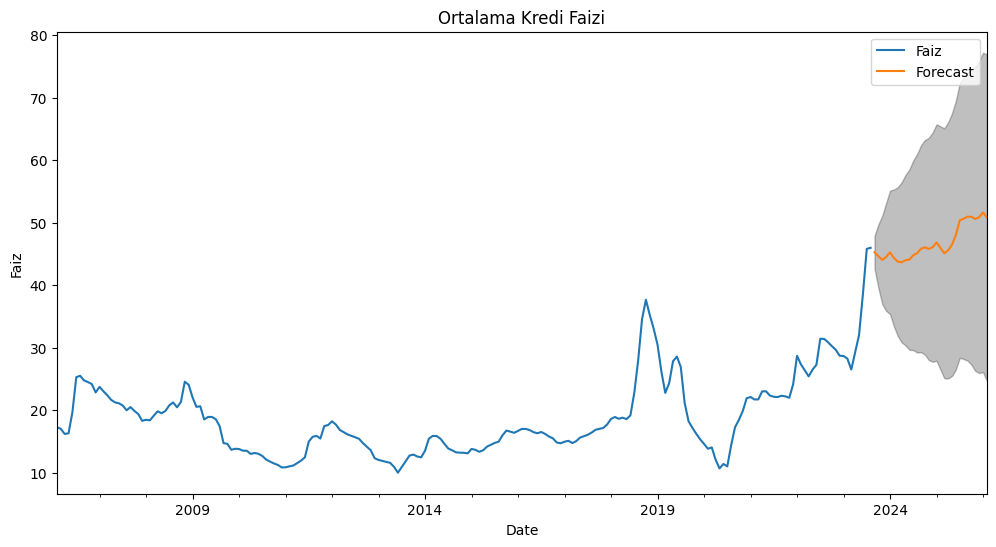

In [69]:
ax = df4.plot(label='observed', figsize=(12, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Faiz')
plt.title("Ortalama Kredi Faizi")

plt.legend()

plt.show()

In [67]:
pred_ci['Mean'] = (pred_ci["lower Faiz"] + pred_ci["upper Faiz"])/2
faiztahmin=pred_ci["Mean"]
faiztahmin=pd.concat([df4["Faiz"].tail(1),faiztahmin])
faiztahmin

2023-08-01    45.995000
2023-09-01    45.283979
2023-10-01    44.644032
2023-11-01    44.058077
2023-12-01    44.529089
2024-01-01    45.263673
2024-02-01    44.368274
2024-03-01    43.781477
2024-04-01    43.664705
2024-05-01    44.014813
2024-06-01    44.104005
2024-07-01    44.801120
2024-08-01    45.125240
2024-09-01    45.841413
2024-10-01    46.077314
2024-11-01    45.805237
2024-12-01    46.097150
2025-01-01    46.840249
2025-02-01    45.982433
2025-03-01    45.116921
2025-04-01    45.581766
2025-05-01    46.505983
2025-06-01    48.042349
2025-07-01    50.385637
2025-08-01    50.655425
2025-09-01    50.971989
2025-10-01    50.954264
2025-11-01    50.601836
2025-12-01    50.896343
2026-01-01    51.658909
2026-02-01    50.813460
dtype: float64

In [119]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
import pandas as pd
import statsmodels.api as sm

# Verileri yükleyin ve ön işleme yapın

# Modeli eğitin

# Özellikleri sabit terim ekleyerek modeli yeniden eğitin
X_train_with_const = sm.add_constant(X_train)

# OLS (En Küçük Karelerle) modelini oluşturalım ve eğitelim
model_ols = sm.OLS(y_train, X_train_with_const)
results = model_ols.fit()










res2=[]
res3=[]
res4=[]
res5=[]
res6=[]
res7=[]
for i in range(31):
    res2.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res3.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res4.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res5.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Tahmin"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 2"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res6.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 2"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 3"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i])
    res7.append(results.params["const"]+results.params["Onceki USD/TL"]*usdtahmin["USD Tahmin Assumption 2"][i]+results.params["Para Arzi Onceki"]*paraarzitahmin["Para Arzi Assumption 3"][i]+results.params["Kredi"]*kreditahmin["Kredi Tahmin Assumption 3"][i]+results.params["Brent"]*brenttahmin["Brent"][i]+results.params["Faiz"]*faiztahmin[i]

)


df9=pd.DataFrame()
dates=pd.date_range('2023-08-01','2026-03-01' , freq='1M')-pd.offsets.MonthBegin(1)
df9["Inflation"]=res2
df9["Assumption 2 Inflation"]=res3
df9["Assumption 3 Inflation"]=res4
df9["Assumption 4 Inflation"]=res5
df9["Assumption 5 Inflation"]=res6
df9["Assumption 6 Inflation"]=res7
df9['TIME']=dates
df9=df9.set_index(dates)
del df9['TIME']
df9

c:\Users\Bora\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,Inflation,Assumption 2 Inflation,Assumption 3 Inflation,Assumption 4 Inflation,Assumption 5 Inflation,Assumption 6 Inflation
2023-08-01,1569.112989,1569.112989,1569.112989,1560.261996,1560.261996,1560.261996
2023-09-01,1609.566777,1582.251348,1596.209576,1598.445211,1579.296347,1565.668217
2023-10-01,1640.240731,1587.868188,1616.248396,1638.824073,1600.057101,1572.293040
2023-11-01,1701.712589,1620.278406,1666.073108,1682.056592,1620.673214,1578.249925
2023-12-01,1776.160550,1662.140303,1727.022172,1728.120516,1642.441978,1584.820223
2024-01-01,1866.513992,1724.911225,1809.574198,1776.165510,1665.491500,1592.115636
2024-02-01,1920.523734,1752.355788,1856.053683,1824.960796,1690.030820,1600.328323
2024-03-01,1983.569566,1779.772297,1904.799655,1874.827560,1713.340106,1606.721082
2024-04-01,2062.268946,1819.943952,1973.001972,1932.851405,1738.098006,1613.954689
2024-05-01,2133.747819,1850.733851,2033.157022,1992.439356,1763.077956,1620.784187


In [120]:
dff=pd.concat([df["CPI"].head(210),df9["Inflation"]],axis=0)
dff=pd.DataFrame(dff)
dff.columns=["CPI"]



dfas2=pd.concat([df["CPI"].head(210),df9["Assumption 2 Inflation"]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["CPI"]
dfas2


dfas3=pd.concat([df["CPI"].head(210),df9["Assumption 3 Inflation"]],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["CPI"]

dfas4=pd.concat([df["CPI"].head(210),df9["Assumption 4 Inflation"]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=["CPI"]

dfas5=pd.concat([df["CPI"].head(210),df9["Assumption 5 Inflation"]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=["CPI"]

dfas6=pd.concat([df["CPI"].head(210),df9["Assumption 6 Inflation"]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=["CPI"]


In [121]:
import pandas as pd

# Örnek DataFrame oluşturalım (gerçek verilere göre değiştirin)
# Diyelim ki veriler 'tufe' sütununda ve 'tarih' sütununda saklanıyor




# 12 ay önceki tüfe değerlerini içeren bir sütun ekleyin
dff['onceki_yil_tufe'] = dff['CPI'].shift(12)
dfas2['onceki_yil_tufe'] = dfas2['CPI'].shift(12)
dfas3['onceki_yil_tufe'] = dfas3['CPI'].shift(12)
dfas4['onceki_yil_tufe'] = dfas4['CPI'].shift(12)
dfas5['onceki_yil_tufe'] = dfas5['CPI'].shift(12)
dfas6['onceki_yil_tufe'] = dfas6['CPI'].shift(12)

# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
dff['yillik_enflasyon_orani'] = ((dff['CPI'] / dff['onceki_yil_tufe']) - 1) * 100
dfas2['yillik_enflasyon_orani'] = ((dfas2['CPI'] / dfas2['onceki_yil_tufe']) - 1) * 100
dfas3['yillik_enflasyon_orani'] = ((dfas3['CPI'] / dfas3['onceki_yil_tufe']) - 1) * 100
dfas4['yillik_enflasyon_orani'] = ((dfas4['CPI'] / dfas4['onceki_yil_tufe']) - 1) * 100
dfas5['yillik_enflasyon_orani'] = ((dfas5['CPI'] / dfas5['onceki_yil_tufe']) - 1) * 100
dfas6['yillik_enflasyon_orani'] = ((dfas6['CPI'] / dfas6['onceki_yil_tufe']) - 1) * 100

# NaN değerleri (ilk 12 ay) veriden çıkarın
dff.dropna(inplace=True)
dfas2.dropna(inplace=True)
dfas3.dropna(inplace=True)
dfas4.dropna(inplace=True)
dfas5.dropna(inplace=True)
dfas6.dropna(inplace=True)

# Sonuçları başka bir DataFrame'e kopyalayın (gerekirse)
result_df = dff[['yillik_enflasyon_orani']].copy()

result_df


,yillik_enflasyon_orani
2007-02-01,10.158269
2007-03-01,10.863263
2007-04-01,10.719962
2007-05-01,9.227769
2007-06-01,8.598305
...,...
2025-10-01,59.628637
2025-11-01,60.488847
2025-12-01,61.447323
2026-01-01,62.728575


In [122]:
dfas6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani
2007-02-01,136.420000,123.840000,10.158269
2007-03-01,137.670000,124.180000,10.863263
2007-04-01,139.330000,125.840000,10.719962
2007-05-01,140.030000,128.200000,9.227769
2007-06-01,139.690000,128.630000,8.598305
...,...,...,...
2025-10-01,1747.229248,1654.931523,5.577133
2025-11-01,1754.289412,1660.600217,5.641887
2025-12-01,1762.694081,1668.374576,5.653377
2026-01-01,1771.958968,1677.295702,5.643803


In [123]:
dfas2=dfas2.head(228)
dfas3=dfas3.head(228)
dfas4=dfas4.head(228)
dfas5=dfas5.head(228)
dfas6=dfas6.head(228)

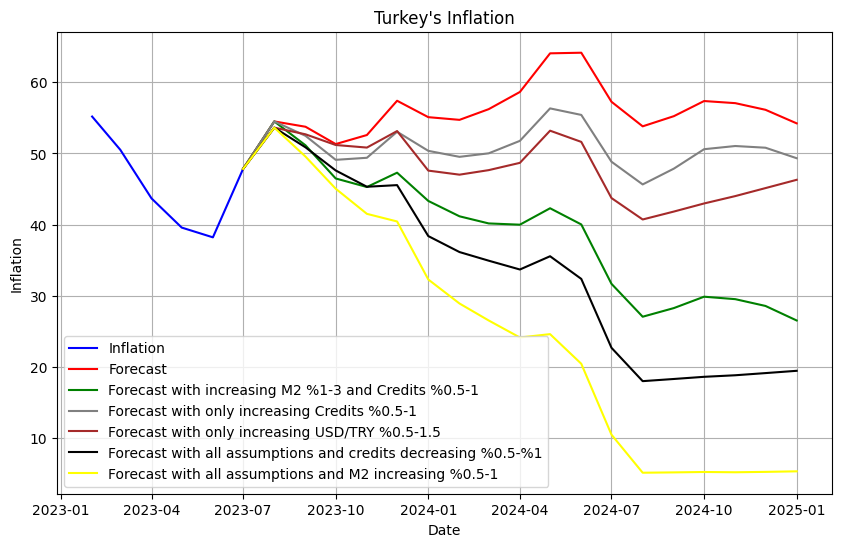

In [129]:
dates=pd.date_range('2008-02-01','2026-02-01' , freq='1M')-pd.offsets.MonthBegin(1)



# Grafik çizdirelim
plt.figure(figsize=(10, 6))
plt.plot(dff.iloc[192:198]["yillik_enflasyon_orani"], label='Inflation', color='blue')
plt.plot(dff.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast', color='red')
plt.plot(dfas2.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with increasing M2 %1-3 and Credits %0.5-1', color='green')
plt.plot(dfas3.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with only increasing Credits %0.5-1', color='gray')
plt.plot(dfas4.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with only increasing USD/TRY %0.5-1.5', color='brown')
plt.plot(dfas5.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with all assumptions and credits decreasing %0.5-%1', color='black')
plt.plot(dfas6.iloc[197:216]["yillik_enflasyon_orani"],label='Forecast with all assumptions and M2 increasing %0.5-1', color='yellow')

plt.xlabel('Date')
plt.ylabel('Inflation')
plt.title("Turkey's Inflation")
plt.legend()
plt.grid(True)
plt.show()


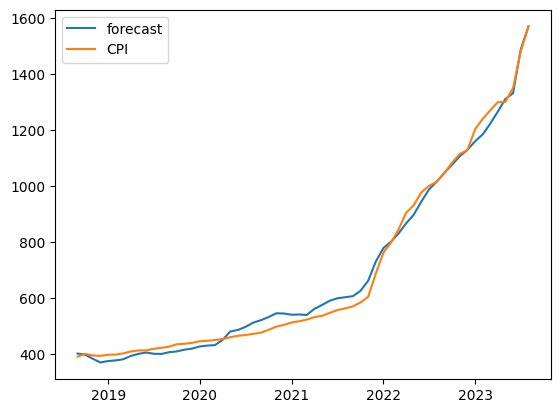

In [91]:
res6=[]
for i in range(-211,0):
    res6.append(results.params["const"]+results.params["USD/TL"]*df6["Onceki USD/TL"][i]+results.params["Para Arzi Onceki"]*dfn["Para Arzi Onceki"][i]+results.params["Kredi"]*df3["Kredi"][i]+results.params["Brent"]*df14["Brent"][i]+results.params["Faiz"]*df4["Faiz"][i])
res6=pd.DataFrame(res6)
res6=res6.set_index(df.index)
res6.columns=["CPI"]
plt.plot(res6.tail(60),label="forecast")
plt.plot(df.tail(60),label="CPI")
plt.legend()

In [92]:
res6['onceki_yil_tufe'] = res6['CPI'].shift(12)


# Yüzde artışı hesaplayın ve 'yillik_enflasyon_orani' sütununu ekleyin
res6['yillik_enflasyon_orani'] = ((res6['CPI'] / res6['onceki_yil_tufe']) - 1) * 100


# NaN değerleri (ilk 12 ay) veriden çıkarın
res6.dropna(inplace=True)
res6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani
2007-02-01,143.254915,134.574489,6.450275
2007-03-01,145.006513,136.612726,6.144220
2007-04-01,145.525264,138.654128,4.955594
2007-05-01,145.590964,138.292997,5.277178
2007-06-01,147.189416,143.009221,2.923025
...,...,...,...
2023-04-01,1266.123596,867.103797,46.017536
2023-05-01,1311.080823,897.647629,46.057404
2023-06-01,1332.226055,945.210601,40.944891
2023-07-01,1487.043247,988.019511,50.507478


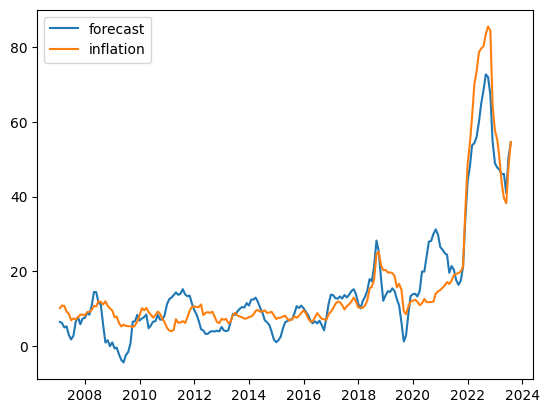

In [93]:
plt.plot(res6["yillik_enflasyon_orani"],label="forecast")
plt.plot(result_df.head(199),label="inflation")
plt.legend()

In [94]:
dff["Onceki Ay TUFE"]=dff["CPI"].shift(1)

In [95]:
res6["Onceki Ay TUFE"]=res6["CPI"].shift(1)
res6.iloc[0,3]=1421
res6["Aylık Enflasyon Tahmin"]=((res6["CPI"]/res6["Onceki Ay TUFE"]-1)*100)
res6["Gerceklesen Aylık Enflasyon"]=((dff["CPI"].head(219)/dff["Onceki Ay TUFE"].head(219)-1)*100)
res6

,CPI,onceki_yil_tufe,yillik_enflasyon_orani,Onceki Ay TUFE,Aylık Enflasyon Tahmin,Gerceklesen Aylık Enflasyon
2007-02-01,143.254915,134.574489,6.450275,1421.000000,-89.918725,NaN
2007-03-01,145.006513,136.612726,6.144220,143.254915,1.222714,0.916288
2007-04-01,145.525264,138.654128,4.955594,145.006513,0.357744,1.205782
2007-05-01,145.590964,138.292997,5.277178,145.525264,0.045147,0.502404
2007-06-01,147.189416,143.009221,2.923025,145.590964,1.097906,-0.242805
...,...,...,...,...,...,...
2023-04-01,1266.123596,867.103797,46.017536,1221.736997,3.633073,2.385509
2023-05-01,1311.080823,897.647629,46.057404,1266.123596,3.550777,0.043076
2023-06-01,1332.226055,945.210601,40.944891,1311.080823,1.612809,3.920498
2023-07-01,1487.043247,988.019511,50.507478,1332.226055,11.620940,9.488824


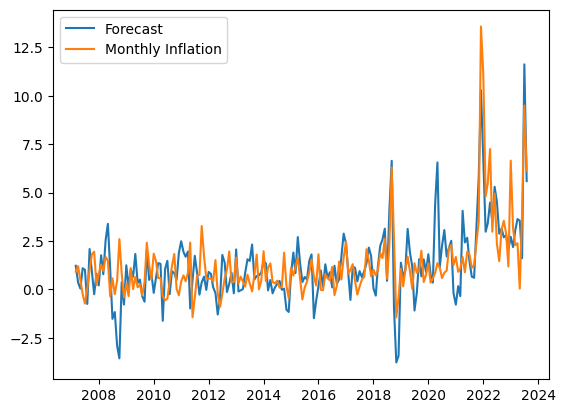

In [96]:
plt.plot(res6["Aylık Enflasyon Tahmin"].tail(198),label="Forecast")
plt.plot(res6["Gerceklesen Aylık Enflasyon"].tail(198),label="Monthly Inflation")
plt.legend()